# Автоматическое определение языка текста

In [1]:
import argparse
import codecs
import unicodedata
import operator

import nltk
import numpy

from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt

%matplotlib inline

Будем решать задачу определения языка печатного текста. В файле `europarl.test.txt` содержатся записи депатов в Европарламенте. Каждая строка содержит код языка и высказывание на этом языке, например, на болгарском:

`bg	(DE) Г-н председател, след повече от 300 години колониално управление и след като континентът се превърна в арена на Студената война, днес Латинска Америка вече е един от нововъзникващите региони в света.`

Код языка будет целевой переменной, а из высказывания нам предстоит извлечь признаки.

Один из возможных подходов состоит в том, чтобы в качестве признаков использовать тройки из подряд идущих символов, встречающихся в словах. Предположение состоит в том, что для каждого языка список наиболее популярных троек более-менее уникален. Попробуем проверить это предположение.

## Считывание данных

In [2]:
DS_PATH = "./europarl.test.txt" # Path to the data file
N_GRAM = 3 # Extract symbol sequences of length N
TOP_TOKENS = 10 # Number of top selected n-grams for each language

In [3]:
def read_documents(data_path):
    """
    Reads a sequence of documents from the text file
    located on a given path.

    Returns:
        A generator of tuples (LANG_CODE, unicode)
    """
    with codecs.open(data_path, 'rU', "utf-8") as data_file:
        for line in data_file:
            lang, doc = line.strip().split('\t')
            yield lang, doc

In [4]:
def normalise_document(doc):
    """
    Convert document to lower-case and remove accents
    
    TODO: Implement this

    Returns:
        A normalised document as unicode
    """
    return ''.join(c for c in unicodedata.normalize('NFD', doc) if not unicodedata.combining(c)).lower()

In [5]:
print normalise_document(u'''cs	Navrhovaný ambiciózní soubor opatření, který předložila Komise, představuje pro Evropskou unii skutečnou výzvu a my, poslanci Evropského parlamentu, budeme usilovat o to, aby byl tento soubor opatření dokončen v roce 2009.''')

cs	navrhovany ambiciozni soubor opatreni, ktery predlozila komise, predstavuje pro evropskou unii skutecnou vyzvu a my, poslanci evropskeho parlamentu, budeme usilovat o to, aby byl tento soubor opatreni dokoncen v roce 2009.


In [8]:
def tokenize_document(doc, n):
    """
    Split document in N-Grams
    
    TODO: implement this

    Returns:
        Iterable (generator or list) of unicode n-grams
    """
    res = []
    tokenizer = nltk.WordPunctTokenizer()
    for token in tokenizer.tokenize(doc):
        if len(token) >= n:
            for ngram in nltk.ngrams(token, n):
                res.append(u"".join(ngram))
    return res

In [9]:
print tokenize_document('''cs navrhovany ambiciozni soubor opatreni, ktery predlozila komise, predstavuje pro evropskou unii skutecnou vyzvu a my, poslanci evropskeho parlamentu, budeme usilovat o to, aby byl tento soubor opatreni dokoncen v roce 2009.''', 3)

[u'nav', u'avr', u'vrh', u'rho', u'hov', u'ova', u'van', u'any', u'amb', u'mbi', u'bic', u'ici', u'cio', u'ioz', u'ozn', u'zni', u'sou', u'oub', u'ubo', u'bor', u'opa', u'pat', u'atr', u'tre', u'ren', u'eni', u'kte', u'ter', u'ery', u'pre', u'red', u'edl', u'dlo', u'loz', u'ozi', u'zil', u'ila', u'kom', u'omi', u'mis', u'ise', u'pre', u'red', u'eds', u'dst', u'sta', u'tav', u'avu', u'vuj', u'uje', u'pro', u'evr', u'vro', u'rop', u'ops', u'psk', u'sko', u'kou', u'uni', u'nii', u'sku', u'kut', u'ute', u'tec', u'ecn', u'cno', u'nou', u'vyz', u'yzv', u'zvu', u'pos', u'osl', u'sla', u'lan', u'anc', u'nci', u'evr', u'vro', u'rop', u'ops', u'psk', u'ske', u'keh', u'eho', u'par', u'arl', u'rla', u'lam', u'ame', u'men', u'ent', u'ntu', u'bud', u'ude', u'dem', u'eme', u'usi', u'sil', u'ilo', u'lov', u'ova', u'vat', u'aby', u'byl', u'ten', u'ent', u'nto', u'sou', u'oub', u'ubo', u'bor', u'opa', u'pat', u'atr', u'tre', u'ren', u'eni', u'dok', u'oko', u'kon', u'onc', u'nce', u'cen', u'roc', u'oce',

Первым делом нам необходимо зачитать данные из файла. Будем читать 3 структуры данных:

- docs - список словарей, каждый из которых соответствует одному документу и содержит количество вхождений для каждой n-граммы (токена)
- langs - список, содержащий классы докуметов (каждому коду языка соответствует числовой класс)
- lang_freq - словарь, который нужен для подсчета ниболее популярных n-грам для каждого языка. Элементы этого словаря: код языка -> (id класса, частоты n-грам (аналогично docs)) 

Для того, чтобы заработал код, зачитывающий данные, необходимо (до) реализовать функции, перечисленные выше.

In [10]:
# A list of dicts, each representing one document in format:
# {token: count1, ...}
docs = []
# Language code for each dict (0-based)
langs = []
# A list of tuples, each tuple corresponds to one language
# First compunent is the code of the language, second is its token frequencies
# Contains entries like {lang_code: (lang_id, {token_frequencies})}
lang_freq = {}

for lang, doc in read_documents(DS_PATH):
    normalized_doc = normalise_document(doc)

    token_freq = {}
    for token in tokenize_document(normalized_doc, N_GRAM):
        token_freq[token] = 1 + token_freq.get(token, 0)
        if lang not in lang_freq:
            print "Found language %s: %d" % (lang, len(lang_freq))
            lang_freq[lang] = (len(lang_freq), {})
        lang_freq[lang][1][token] = 1 + lang_freq[lang][1].get(token, 0)

    docs.append(token_freq)
    langs.append(lang_freq[lang][0])

Found language bg: 0
Found language cs: 1
Found language da: 2
Found language de: 3
Found language el: 4
Found language en: 5
Found language es: 6
Found language et: 7
Found language fi: 8
Found language fr: 9
Found language hu: 10
Found language it: 11
Found language lt: 12
Found language lv: 13
Found language nl: 14
Found language pl: 15
Found language pt: 16
Found language ro: 17
Found language sk: 18
Found language sl: 19
Found language sv: 20


## Отбор признаков

Здесь предстоит выбрать топовые n-граммы для каждого языка (`select_features`) и отфильтровать документы так, чтобы в них остались только отобранные (`keep_only_features`)

In [14]:
def select_features(lang_freq, top_tokens):
    """
    From each language selects top_tokens to be used as features
    
    TODO: Implement this

    Returns:
        set(unicode tokens)
    """
    features = set()
    for lang, (lid, token_freq) in lang_freq.iteritems():
        for token in sorted(token_freq, key=token_freq.get, reverse=True)[:top_tokens]:
            features.add(token)
        #if token_freq >= top_tokens: features.add(lang[lid])
    return features

In [15]:
def keep_only_features(docs, features):
    """
    Removes non-feature tokens from the document representations
    """
    for token_freq in docs:
        for token in token_freq.keys():
            if token not in features:
                del token_freq[token]

In [16]:
# Select top n features for each lang
features = select_features(lang_freq, TOP_TOKENS)
# Remove from documents all features except the selected
keep_only_features(docs, features)

# Transform documents to numpy matrix
dv = DictVectorizer()
x = dv.fit_transform(docs).todense()
y = numpy.array(langs)
print "Data set shape x=(%d x %d) y=%d" % (x.shape[0], x.shape[1], len(y))

Data set shape x=(21000 x 151) y=21000


## Создание и настройка модели

В этом пункте требуется инициализировать модель (NB) и перебрать различные значения параметров. Предлагается попробовать Multinumial и Bernoulli варианты из sklearn и несколько значений параметров (alpha, binarize, fit_prior) и выбрать наилучшую модель на основании метрики `accuracy`, полученной на кросс-валидации.

In [21]:
def create_model():
    """
    Initialise an NB model, supported by Sklearn

    Returns:
        Sklearn model instance
    """
    return MultinomialNB()

In [25]:
def validate_model(model, x, y, folds=10):
    """
    Computes cross-validation score for the given data set and model.
    
    TODO: Implement this

    Returns:
        A numpy.array of accuracy scores.
    """
    scores = cross_val_score(model, x, y, cv = folds)
    return scores

In [26]:
def plot_roc(model, x, y, class_ind=0):    
    # Compute ROC curve
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.5, random_state=0)
    fit = model.fit(x_train, y_train)
    y_prob = fit.predict_proba(x_test)    
    fpr, tpr, _ = roc_curve(y_test, y_prob[:, class_ind], pos_label=class_ind)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.fill_between(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for class index %s' % class_ind)

_Замечание_ : обратите внимание, что тут нужно реализовать перебор параметров.

Model mean accuracy: 0.883904761905


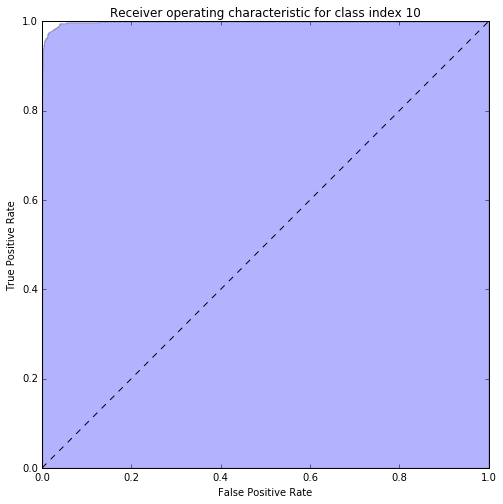

In [28]:
# TODO: Implement parameter grid search here
model = create_model()
# Print cross-validated accturacy
scores = validate_model(model, x, y)
print "Model mean accuracy: {}".format(numpy.mean(scores))

# Plot ROC
plt.figure(figsize=(8, 8))
plot_roc(model, x, y, 10)
plt.show()

## Дополнительно

- Выясните, какие классы чаще всего путаются (на кросс-валидации!)
- Сравните NB и KNN